In [1]:
# Montar o google drive no coolab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, RobertaTokenizer, BertTokenizerFast, BertModel, BertForSequenceClassification
import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn import metrics

import pickle
import re
import os
from tqdm import tqdm
import ast
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset


## Importando DataFrames

In [3]:
# df_train_use.to_csv('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\data\\clean\\clean_train_corpus.csv', index=False)
# df_train_use = pd.read_csv('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\data\\clean\\clean_train_corpus.csv')
# df_train_use = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/BERT/clean_train_corpus.csv') # Versão colab

# df_test_use.to_csv('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\data\\clean\\clean_test_corpus.csv', index=False)
# df_test_use = pd.read_csv('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\data\\clean\\clean_test_corpus.csv')
df_test_use = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/BERT/clean_test_corpus.csv') # Versão colab

In [ ]:
df_test_use.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"['09-Feb-2021 08:23', '09-Feb-2021 08:49', '09...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"['20-Aug-2020 00:22', '20-Aug-2020 19:41', '20...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","['08-Nov-2020 21:33', '08-Nov-2020 21:39', '08...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"['10-Jul-2020 21:52', '10-Jul-2020 22:02', '10...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"['02-May-2018 22:37', '02-May-2018 22:39', '02...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...


## Funções para métrica de avaliação f1-latency


Para cálculo da métrica de interesse f1-*latency* são necessárias algumas etapas representadas pelas funções abaixo.

In [4]:
def value_p(k):
    """Get the penalty value for the F latency measure.

    Parameters
    ----------
    k : int
        Median number of posts from the positive users.

    Returns
    -------
    penalty : float
        Penalty to use.
    """
    return -(np.log(1 / 3) / (k - 1))


def f_penalty(k, _p):
    """Get the penalty of the current user delay.

    Parameters
    ----------
    k : int
        Current user delay.
    _p : float
        Penalty.

    Returns
    -------
    f_penalty : float
        Penalty latency.
    """
    return -1 + (2 / (1 + np.exp((-_p) * (k - 1))))


def speed(y_pred, y_true, d, p):
    """Get speed for every user correctly classified as positive."""
    penalty_list = [
        f_penalty(k=d[i], _p=p)
        for i in range(len(y_pred))
        if y_pred[i] == 1 and y_true[i] == 1
    ]

    if len(penalty_list) != 0:
        return 1 - np.median(penalty_list)
    else:
        return 0.0


def f_latency(labels, true_labels, delays, penalty):
    """F latency metric.

    Metric proposed by Sadeque and others in [1]_.

    Parameters
    ----------
    labels : list of int
        Predicted label for each user.
    true_labels : list of int
        True label for each user.
    delays : list of int
        Decision delay for each user.
    penalty : float
        Penalty. Defines how quickly the penalty should increase.

    Returns
    -------
    f_latency_metric : float
        F latency measure.

    References
    ----------
    .. [1] `Sadeque, F., Xu, D., & Bethard, S. (2018, February). Measuring the
        latency of depression detection in social media. In Proceedings of the
        Eleventh ACM International Conference on Web Search and Data Mining
        (pp. 495-503).`_
    """
    f1_score = metrics.f1_score(y_pred=labels, y_true=true_labels, average="binary")
    speed_value = speed(y_pred=labels, y_true=true_labels, d=delays, p=penalty)

    return f1_score * speed_value

## Data Prep

In [5]:
df_test_use_baseline = df_test_use.copy()
# df_test_use_baseline.head()

In [6]:
# Transformo a timeline em listas
def timeline_list(text):
    return text.split('$END_OF_POST$')

df_test_use_baseline['List_CleanText'] = df_test_use_baseline['CleanText'].apply(timeline_list)


# Faço a contagem de posts
def contar_posts(texto):
    return texto.count('$END_OF_POST$') + 1

df_test_use_baseline['Qt_Messages'] = df_test_use_baseline['CleanText'].apply(contar_posts)
# df_test_use_baseline.head()

## Treinando BoW com Regressão Logística

In [ ]:
# Carregar o bag-of-words do arquivo .pkl
with open('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/bag_of_words_model.pkl', 'rb') as f:
    count_vect, tf_transformer = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Treinando com o melhor classificador

In [ ]:
################################################################ Bag-of-words ################################################################
# X_train_counts = count_vect.transform(df_train_use['CleanText'])
# X_train_tf = tf_transformer.transform(X_train_counts)
# y_train_tf = df_train_use['Diagnosed_YN']

################################################################ Word2Vec ################################################################
import gensim
from gensim.models import Word2Vec

# Transforme os textos em uma lista de listas de palavras
sentences = df_train_use['Text'].apply(lambda x: x.split()).tolist()

# Treine o modelo Word2Vec
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Função para calcular a média dos vetores das palavras
def text_vector(text, model):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vecs, axis=0)

X_train_tf = df_train_use['Text'].apply(lambda x: text_vector(x, model_w2v)).tolist()
X_train_tf = np.array(X_train_tf)
y_train_tf = df_train_use['Diagnosed_YN']

In [ ]:
# Treinando a Regressão Linear
clf = LogisticRegression(random_state=42)
clf.fit(X_train_tf, y_train_tf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
y_pred = clf.predict(X_train_tf)

In [ ]:
print(classification_report(y_train_tf, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9429
           1       0.58      0.06      0.11      1347

    accuracy                           0.88     10776
   macro avg       0.73      0.53      0.52     10776
weighted avg       0.84      0.88      0.83     10776



In [ ]:
save_path = '/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/'
# Salvar o modelo no arquivo .pkl
with open(os.path.join(save_path, 'modelo.pkl'), 'wb') as f:
    pickle.dump(clf, f)

## Política DMC - Momento de Decisão da Classificação
Os parâmetros usados nesta política foram de limiar = 0.7 e número mínimo de mensagens lidas de 10.

#### Teste 1 - Utilizando a política como está descrita no artigo

In [7]:
# Carregando o modelo SVM a partir do arquivo .pkl
with open('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/modelo.pkl', 'rb') as f:
    clf = pickle.load(f)

In [8]:
# Carregar o bag-of-words do arquivo .pkl
with open('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/bag_of_words_model.pkl', 'rb') as f:
    count_vect, tf_transformer = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Preparação dos dados de teste

In [9]:
menor_timeline = df_test_use_baseline['Qt_Messages'].min()

def min_timeline(lista):
    return lista[- menor_timeline:]

df_test_use_baseline['List_CleanText_min'] = df_test_use_baseline['List_CleanText'].apply(min_timeline)
# df_test_use_baseline.head()

In [11]:
# Testando uma otimização no tempo de processamento
# Parâmetros
delta = 0.5
n = 10

# Criando objetos auxiliares
# qtd_msgs_lidas = np.zeros(len(df_test_use_baseline), dtype=int)
qtd_msgs_lidas = list(df_test_use_baseline['Qt_Messages'])
df_test_use_baseline['prediction'] = 0

# Avaliando a previsão e calculando a quantidade de mensagens lidas
for i, lista in tqdm(enumerate(df_test_use_baseline['List_CleanText_min'])):
    # Concatenando as mensagens em um único documento
    concatenated_messages = ['$END_OF_POST$'.join(lista[j:j+n]) for j in range(0, len(lista))]

    # Usando Bag-of-words
    # Transformando o documento em uma matriz de contagem de palavras
    X_train_counts_teste = count_vect.transform(concatenated_messages)
    X_train_tf_teste = tf_transformer.transform(X_train_counts_teste)


    # # Usando o Word2Vec
    # # Criar vetores para cada mensagem concatenada
    # all_vectors = []
    # vectors = [text_vector(message, model_w2v) for message in concatenated_messages]
    # all_vectors.append(vectors)

    # X_train_tf_teste = [np.mean(vectors, axis=0) for vectors in all_vectors]
    # X_train_tf_teste = np.array(X_train_tf_teste)

    # Prevendo usando o modelo SVM
    y_pred = clf.predict(X_train_tf_teste)
    prob = clf.predict_proba(X_train_tf_teste)

    # Encontrando o índice da primeira mensagem que satisfaz os critérios
    idx = np.argmax((y_pred == 1) & (prob.max(axis=1) >= delta))

    # Atualizando o dataframe e a quantidade de mensagens lidas
    if (y_pred[idx] == 1) and (prob[idx].max() >= delta):
        df_test_use_baseline.loc[i, 'prediction'] = 1
        qtd_msgs_lidas[i] = (idx + n)

df_test_use_baseline['qtd_msgs_lidas'] = qtd_msgs_lidas


2696it [00:32, 84.17it/s] 


In [12]:
df_test_use_baseline.to_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/prediction_w2vreglog_MinTL.pkl')

### Avaliando sistema

In [ ]:
# W2V
y_train_teste_1 = df_test_use_baseline['Diagnosed_YN']
y_pred_teste_1 = df_test_use_baseline['prediction']
print(classification_report(y_train_teste_1, y_pred_teste_1))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2359
           1       0.32      0.31      0.32       337

    accuracy                           0.83      2696
   macro avg       0.61      0.61      0.61      2696
weighted avg       0.83      0.83      0.83      2696



In [ ]:
# BoW
y_train_teste_1 = df_test_use_baseline['Diagnosed_YN']
y_pred_teste_1 = df_test_use_baseline['prediction']
print(classification_report(y_train_teste_1, y_pred_teste_1))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2359
           1       0.38      0.19      0.25       337

    accuracy                           0.86      2696
   macro avg       0.63      0.57      0.59      2696
weighted avg       0.83      0.86      0.84      2696



In [ ]:
# W2V
f1_latency = f_latency(df_test_use_baseline['prediction'], df_test_use_baseline['Diagnosed_YN'], df_test_use_baseline['qtd_msgs_lidas'], 0.0078)
f1_latency

0.30655374517030537

In [ ]:
# BoW
f1_latency = f_latency(df_test_use_baseline['prediction'], df_test_use_baseline['Diagnosed_YN'], df_test_use_baseline['qtd_msgs_lidas'], 0.0078)
f1_latency

0.20384936682450158

In [ ]:
df_test_use_baseline['prediction'].value_counts()

,count
prediction,
0,2526
1,170


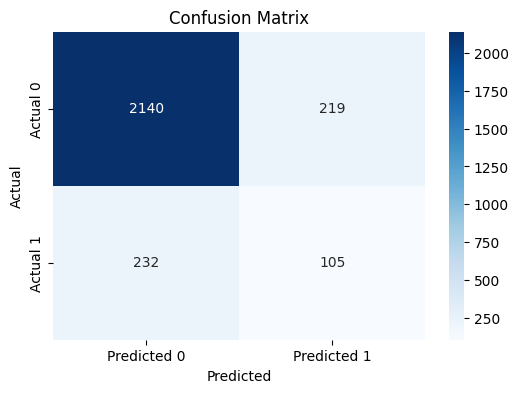

In [ ]:
# W2V
# Confusion matrix
cm = confusion_matrix(df_test_use_baseline['Diagnosed_YN'], df_test_use_baseline['prediction'])

# Exibindo a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

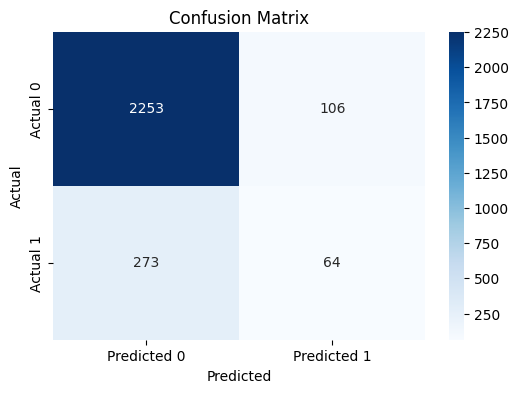

In [ ]:
# BoW
# Confusion matrix
cm = confusion_matrix(df_test_use_baseline['Diagnosed_YN'], df_test_use_baseline['prediction'])

# Exibindo a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Tempo de antecipação do risco

In [ ]:
df_test_use_baseline.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText,List_CleanText,Qt_Messages,prediction,qtd_msgs_lidas,ultima_data_tweet_lido,ultima_data_tweet_lista
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"['09-Feb-2021 08:23', '09-Feb-2021 08:49', '09...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...,"[esse trabalho incrvel, por deus eu amo o davi...",507,0,507,1,]
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"['20-Aug-2020 00:22', '20-Aug-2020 19:41', '20...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...,"[eras, mds eu tenho mais de number temas pra f...",1463,0,1463,,]
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","['08-Nov-2020 21:33', '08-Nov-2020 21:39', '08...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...,[eu sou nova no edtwt gostaria de encontrar mu...,1426,1,10,3,]
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"['10-Jul-2020 21:52', '10-Jul-2020 22:02', '10...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...,[de number semana dormindo por volta das 20h e...,1761,1,170,1,]
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"['02-May-2018 22:37', '02-May-2018 22:39', '02...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...,"[noite primeiramente, caramba como que usa ess...",1447,1,790,4,]


In [ ]:
from datetime import datetime

# Função para converter a lista de datas em objetos datetime
def converter_datas(lista_datas_str):
    # Remover os colchetes e espaços em branco
    lista_datas_str = lista_datas_str.strip('[]').replace("'", "").split(', ')
    # Converter cada data para datetime
    return [pd.to_datetime(data_str, format='%d-%b-%Y %H:%M') for data_str in lista_datas_str]


# Função para calcular a diferença em dias entre duas datas
def calcular_diferenca_dias(data1, data2):
    delta = data1 - data2
    return delta.days

# Aplicando a conversão de datas ao DataFrame
df_test_use_baseline['List_Timeline'] = df_test_use_baseline['List_Timeline'].apply(converter_datas)

# Aplicando a função ao DataFrame
df_test_use_baseline['ultima_data_tweet_lido'] = df_test_use_baseline.apply(lambda row: row['List_Timeline'][row['qtd_msgs_lidas'] - 1], axis=1)
df_test_use_baseline['ultima_data_tweet_lista'] = df_test_use_baseline.apply(lambda row: row['List_Timeline'][-1], axis=1)
df_test_use_baseline['dias_antecipados'] = df_test_use_baseline.apply(lambda row: calcular_diferenca_dias(row['ultima_data_tweet_lista'], row['ultima_data_tweet_lido']), axis=1)

df_test_use_baseline.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText,List_CleanText,Qt_Messages,List_CleanText_min,prediction,qtd_msgs_lidas,ultima_data_tweet_lido,ultima_data_tweet_lista,dias_antecipados
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"[2021-02-09 08:23:00, 2021-02-09 08:49:00, 202...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...,"[esse trabalho incrvel, por deus eu amo o davi...",507,[odeia a olivia pq tem inveja da relao dela c ...,1,17,2021-02-11 23:50:00,2021-05-16 14:14:00,93
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"[2020-08-20 00:22:00, 2020-08-20 19:41:00, 202...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...,"[eras, mds eu tenho mais de number temas pra f...",1463,"[eu sou horrvel flertando kkkkkkkkk, eucom que...",0,1463,2021-03-07 20:13:00,2021-03-07 20:13:00,0
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","[2020-11-08 21:33:00, 2020-11-08 21:39:00, 202...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...,[eu sou nova no edtwt gostaria de encontrar mu...,1426,"[ahh mesmo eu sempre achei ela to tortinha, ah...",1,19,2020-11-09 10:12:00,2021-01-14 10:19:00,66
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"[2020-07-10 21:52:00, 2020-07-10 22:02:00, 202...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...,[de number semana dormindo por volta das 20h e...,1761,[o bombom sensao o melhor da caixinha e quem d...,0,1761,2021-05-01 00:45:00,2021-05-01 00:45:00,0
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"[2018-05-02 22:37:00, 2018-05-02 22:39:00, 201...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...,"[noite primeiramente, caramba como que usa ess...",1447,"[o que foi esse tweet meu deus, bom dia s pra ...",0,1447,2018-07-01 18:43:00,2018-07-01 18:43:00,0


In [ ]:
dias_antecipacao_geral = df_test_use_baseline['dias_antecipados'].mean()
dias_antecipacao_pos = df_test_use_baseline[df_test_use_baseline['Diagnosed_YN']==1]['dias_antecipados'].mean()
print(f'Média de dias de antecipação de risco geral: {dias_antecipacao_geral}')
print(f'Média de dias de antecipação de risco da classe positiva: {dias_antecipacao_pos}')

Média de dias de antecipação de risco geral: 19.982566765578635
Média de dias de antecipação de risco da classe positiva: 60.72997032640949


In [ ]:
df_test_use_baseline.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/prediction_baseline_RL_MinTL.csv', index=False)
# df_test_use_baseline = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/baseline/prediction_baseline_RL_MinTL.csv')

#### Teste 2 - Utilizando as semanas como cortes

In [ ]:
df_test_use_baseline_week = df_test_use_baseline.copy()
df_test_use_baseline_week.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText,List_CleanText,Qt_Messages,prediction,qtd_msgs_lidas
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"['09-Feb-2021 08:23', '09-Feb-2021 08:49', '09...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...,"[esse trabalho incrvel, por deus eu amo o davi...",507,0,0
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"['20-Aug-2020 00:22', '20-Aug-2020 19:41', '20...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...,"[eras, mds eu tenho mais de number temas pra f...",1463,0,0
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","['08-Nov-2020 21:33', '08-Nov-2020 21:39', '08...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...,[eu sou nova no edtwt gostaria de encontrar mu...,1426,0,0
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"['10-Jul-2020 21:52', '10-Jul-2020 22:02', '10...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...,[de number semana dormindo por volta das 20h e...,1761,0,0
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"['02-May-2018 22:37', '02-May-2018 22:39', '02...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...,"[noite primeiramente, caramba como que usa ess...",1447,0,0


In [ ]:
# Carregando o modelo SVM a partir do arquivo .pkl
with open('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\model\\01. baseline\\svm.pkl', 'rb') as f:
    svm = pickle.load(f)

# Carregar o bag-of-words do arquivo .pkl
with open('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\model\\01. baseline\\bag_of_words_model.pkl', 'rb') as f:
    count_vect, tf_transformer = pickle.load(f)

c:\Users\Bruno Scale\anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Bruno Scale\anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import ast  # Importando o módulo ast para analisar a string em uma lista

# # Função para fazer previsões para um usuário com no máximo 20 mensagens
# def predict_user_messages(messages, model):
#     # Limitando a quantidade de mensagens a 20
#     if len(messages) > 20:
#         messages = messages[:20]

#     # Vetorizando as mensagens do usuário
#     X_counts = count_vect.transform(messages)
#     X_user = tf_transformer.transform(X_counts)

#     # Fazendo previsões
#     predictions = model.predict(X_user)
#     probabilities = model.predict_proba(X_user)[:, 1]  # Probabilidade da classe positiva

#     messages_read = len(messages)  # Contagem de mensagens lidas

#     # Verificando se alguma previsão é 1 com probabilidade maior que 0.3
#     if any((predictions == 1) & (probabilities > 0.5)):
#         return 1, messages_read
#     else:
#         return 0, messages_read

# df_test_use_baseline_week['prediction'] = 0
# df_test_use_baseline_week['messages_read'] = 0

# # Iterar sobre cada linha do dataframe
# for index, row in tqdm(df_test_use_baseline_week.iterrows()):
#     user_messages = row['List_CleanText']
#     user_weeks = ast.literal_eval(row['Week'])  # Convertendo a string em uma lista de strings

#     messages_read_total = 0  # Inicializando a contagem total de mensagens lidas para este usuário

#     # Iterar sobre cada semana do usuário
#     for week in user_weeks:
#         # Filtrar mensagens da semana atual
#         week_messages = [user_messages[i] for i, w in enumerate(user_weeks) if w == week]

#         # Fazer previsão para as mensagens da semana atual
#         prediction, messages_read = predict_user_messages(week_messages, svm)

#         # Adicionando o número de mensagens lidas nesta semana ao total
#         messages_read_total += messages_read

#         # Se a previsão for 1, imprimir e parar de ler mensagens desse usuário
#         if prediction == 1:
#             print("Para a semana {} do usuário, a previsão é 1.".format(week))
#             row['prediction'] = 1
#             break

#     # Armazenar o número total de mensagens lidas para este usuário
#     row['messages_read'] = messages_read_total

#########################################################################################################################

# Vetorizando todas as mensagens de uma vez
X_counts = count_vect.transform([' '.join(texts) for texts in df_test_use_baseline_week['List_CleanText']])
X_user = tf_transformer.transform(X_counts)

for index, row in tqdm(df_test_use_baseline_week.iterrows()):
    user_weeks = ast.literal_eval(row['Week'])

    messages_read_total = 0

    for week in user_weeks:
        week_indices = [i for i, w in enumerate(user_weeks) if w == week]

        # Usando os vetores pré-processados para a semana atual
        X_week = X_user[week_indices]

        prediction = svm.predict(X_week)
        probabilities = svm.predict_proba(X_week)[:, 1]

        # Verificando se alguma previsão é 1 com probabilidade maior que 0.5
        if any((prediction == 1) & (probabilities > 0.5)):
            print("Para a semana {} do usuário, a previsão é 1.".format(week))
            row['prediction'] = 1
            break

        # Adicionando o número de mensagens lidas nesta semana ao total
        messages_read_total += len(week_indices)

    # Armazenar o número total de mensagens lidas para este usuário
    row['messages_read'] = messages_read_total

3it [21:04:05, 25281.88s/it]


KeyboardInterrupt: 

In [ ]:
df_test_use_baseline_week.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText,List_CleanText,Qt_Messages,prediction,qtd_msgs_lidas,messages_read
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"['09-Feb-2021 08:23', '09-Feb-2021 08:49', '09...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...,"[esse trabalho incrvel, por deus eu amo o davi...",507,0,0,0
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"['20-Aug-2020 00:22', '20-Aug-2020 19:41', '20...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...,"[eras, mds eu tenho mais de number temas pra f...",1463,0,0,0
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","['08-Nov-2020 21:33', '08-Nov-2020 21:39', '08...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...,[eu sou nova no edtwt gostaria de encontrar mu...,1426,0,0,0
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"['10-Jul-2020 21:52', '10-Jul-2020 22:02', '10...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...,[de number semana dormindo por volta das 20h e...,1761,0,0,0
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"['02-May-2018 22:37', '02-May-2018 22:39', '02...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...,"[noite primeiramente, caramba como que usa ess...",1447,0,0,0


In [ ]:
df_test_use_baseline_week.to_csv('C:\\Users\\Bruno Scale\\Documents\\Mestrado\\Experimentos\\data\\prediction\\prediction_baseline_Weeks.csv', index=False)

In [ ]:
y_train_teste = df_test_use_baseline_week['Diagnosed_YN']
y_pred_teste = df_test_use_baseline_week['prediction']
print(classification_report(y_train_teste, y_pred_teste))

In [ ]:
f1_latency = f_latency(df_test_use_baseline_week['prediction'], df_test_use_baseline_week['Diagnosed_YN'], df_test_use_baseline_week['qtd_msgs_lidas'], 0.0078)
f1_latency

#### Teste 3 - Cortando a timeline

In [ ]:
df_train_use_teste_3 = df_train_use.copy()
df_train_use_teste_3

In [ ]:
# Calculando a quantidade de mensagens de cada usuário
df_train_use['Len_text'] = df_train_use.apply(lambda x: len(x['List_Text']), axis=1)
df_train_use.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,text_list,CleanText,len_text,Len_text
0,D_1477,1,@ @ Eu também estou um pouco confusa...$END_OF...,"['16-Jun-2011 11:03', '16-Jun-2011 12:26', '17...","['24', '24', '24', '24', '25', '25', '25', '25...","['@ @ Eu também estou um pouco confusa...', '@...",eu tambm estou um pouco confusa$END_OF_POST$dv...,203636,203636
1,D_983,1,Engraçado ver um cara que tu considerava irmão...,"['27-Mar-2019 19:59', '27-Mar-2019 20:00', '28...","['12', '12', '12', '12', '12', '13', '13', '13...",['Engraçado ver um cara que tu considerava irm...,ver um cara que tu considerava irmo se casar e...,19088,19088
2,D_1205,1,"@ o erro tem que ser reconhecido. falei bosta,...","['15-Oct-2019 14:03', '15-Oct-2019 19:23', '15...","['41', '41', '41', '41', '41', '41', '41', '41...",['@ o erro tem que ser reconhecido. falei bost...,o erro tem que ser reconhecido falei bosta ass...,61361,61361
3,D_1081,1,@ Descobri que esse também é o meu medo$END_OF...,"['02-Aug-2019 22:42', '02-Aug-2019 22:44', '02...","['30', '30', '30', '30', '30', '30', '30', '30...","['@ Descobri que esse também é o meu medo', '@...",descobri que esse tambm o meu medo$END_OF_POST...,96205,96205
4,D_1209,1,eu só nasci mesmo …$END_OF_POST$então vamo te ...,"['17-Jun-2019 21:48', '23-Jun-2019 03:32', '26...","['24', '25', '25', '25', '25', '26', '26', '26...","['eu só nasci mesmo …', 'então vamo te amo bb ...",s nasci mesmo$END_OF_POST$ento vamo te amo bb ...,101638,101638


In [ ]:
print('menor timeline:', df_train_use['Len_text'].min())
print('maior timeline:', df_train_use['Len_text'].max())

menor timeline: 1987
maior timeline: 694539


In [ ]:
df_train_use['List_CleanText'] = df_train_use.apply(lambda x: x['CleanText'].split('$END_OF_POST$'), axis=1)
df_train_use.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,List_Text,CleanText,Len_text,List_CleanText
0,D_1477,1,@ @ Eu também estou um pouco confusa...$END_OF...,"['16-Jun-2011 11:03', '16-Jun-2011 12:26', '17...","['24', '24', '24', '24', '25', '25', '25', '25...","['@ @ Eu também estou um pouco confusa...', '@...",eu tambm estou um pouco confusa$END_OF_POST$dv...,203636,"[eu tambm estou um pouco confusa, dvida ser qu..."
1,D_983,1,Engraçado ver um cara que tu considerava irmão...,"['27-Mar-2019 19:59', '27-Mar-2019 20:00', '28...","['12', '12', '12', '12', '12', '13', '13', '13...",['Engraçado ver um cara que tu considerava irm...,ver um cara que tu considerava irmo se casar e...,19088,[ver um cara que tu considerava irmo se casar ...
2,D_1205,1,"@ o erro tem que ser reconhecido. falei bosta,...","['15-Oct-2019 14:03', '15-Oct-2019 19:23', '15...","['41', '41', '41', '41', '41', '41', '41', '41...",['@ o erro tem que ser reconhecido. falei bost...,o erro tem que ser reconhecido falei bosta ass...,61361,[o erro tem que ser reconhecido falei bosta as...
3,D_1081,1,@ Descobri que esse também é o meu medo$END_OF...,"['02-Aug-2019 22:42', '02-Aug-2019 22:44', '02...","['30', '30', '30', '30', '30', '30', '30', '30...","['@ Descobri que esse também é o meu medo', '@...",descobri que esse tambm o meu medo$END_OF_POST...,96205,"[descobri que esse tambm o meu medo, descobri ..."
4,D_1209,1,eu só nasci mesmo …$END_OF_POST$então vamo te ...,"['17-Jun-2019 21:48', '23-Jun-2019 03:32', '26...","['24', '25', '25', '25', '25', '26', '26', '26...","['eu só nasci mesmo …', 'então vamo te amo bb ...",s nasci mesmo$END_OF_POST$ento vamo te amo bb ...,101638,"[s nasci mesmo, ento vamo te amo bb caraio, mu..."


In [ ]:
df_train_use.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,List_Text,CleanText,Len_text,List_CleanText,Cut_List_CleanText
0,D_1477,1,@ @ Eu também estou um pouco confusa...$END_OF...,"['16-Jun-2011 11:03', '16-Jun-2011 12:26', '17...","['24', '24', '24', '24', '25', '25', '25', '25...","['@ @ Eu também estou um pouco confusa...', '@...",eu tambm estou um pouco confusa$END_OF_POST$dv...,203636,"[eu tambm estou um pouco confusa, dvida ser qu...","[eu tambm estou um pouco confusa, dvida ser qu..."
1,D_983,1,Engraçado ver um cara que tu considerava irmão...,"['27-Mar-2019 19:59', '27-Mar-2019 20:00', '28...","['12', '12', '12', '12', '12', '13', '13', '13...",['Engraçado ver um cara que tu considerava irm...,ver um cara que tu considerava irmo se casar e...,19088,[ver um cara que tu considerava irmo se casar ...,[ver um cara que tu considerava irmo se casar ...
2,D_1205,1,"@ o erro tem que ser reconhecido. falei bosta,...","['15-Oct-2019 14:03', '15-Oct-2019 19:23', '15...","['41', '41', '41', '41', '41', '41', '41', '41...",['@ o erro tem que ser reconhecido. falei bost...,o erro tem que ser reconhecido falei bosta ass...,61361,[o erro tem que ser reconhecido falei bosta as...,[o erro tem que ser reconhecido falei bosta as...
3,D_1081,1,@ Descobri que esse também é o meu medo$END_OF...,"['02-Aug-2019 22:42', '02-Aug-2019 22:44', '02...","['30', '30', '30', '30', '30', '30', '30', '30...","['@ Descobri que esse também é o meu medo', '@...",descobri que esse tambm o meu medo$END_OF_POST...,96205,"[descobri que esse tambm o meu medo, descobri ...","[descobri que esse tambm o meu medo, descobri ..."
4,D_1209,1,eu só nasci mesmo …$END_OF_POST$então vamo te ...,"['17-Jun-2019 21:48', '23-Jun-2019 03:32', '26...","['24', '25', '25', '25', '25', '26', '26', '26...","['eu só nasci mesmo …', 'então vamo te amo bb ...",s nasci mesmo$END_OF_POST$ento vamo te amo bb ...,101638,"[s nasci mesmo, ento vamo te amo bb caraio, mu...","[s nasci mesmo, ento vamo te amo bb caraio, mu..."


In [ ]:
# parâmetros
delta = 0.5
n = 20
max_msgs = 100

# Criando a coluna com a timeline cortada
df_train_use['Cut_List_CleanText'] = df_train_use.apply(lambda x: x['List_CleanText'][:max_msgs], axis=1)

# Criando objetos auxiliares
qtd_msgs_lidas = []
df_train_use_teste_3['prediction'] = 0

# for i in tqdm(range(len(df_train_use))):
for i in tqdm(range(5)):
  for j in range(len(df_train_use_teste_3['List_CleanText'][i])):
    lista_temp = ['$END_OF_POST$'.join(df_train_use_teste_3['List_CleanText'][i][j:j+n])]

    X_train_counts_teste = count_vect.transform(lista_temp)
    X_train_tf_teste = tf_transformer.transform(X_train_counts_teste)

    y_pred = svc.predict(X_train_tf_teste)
    prob = svc.predict_proba(X_train_tf_teste)
    if y_pred == 1 and prob.max() >= delta:
      print(f'Quantidade de mensagens lidas: {j+n}')
      df_train_use_teste_3['prediction'][i] = 1
      break
  qtd_msgs_lidas.append(j+n)

df_train_use_teste_3['qtd_msgs_lidas'] = qtd_msgs_lidas
df_train_use_teste_3.head()